# RBC Calibration Exercise

I begin with log-linearized equilibrium conditions from a simple RBC model with a labor-leisure tradeoff and Cobb-Douglas production.

I pick calibration values for economic parameters based on data/literature.

I estimate $\lambda$ variables to express the model as a state-space model.

Finally, I plot impulse response functions and describe cross-correlations

In [12]:
using Optim;
using Plots;
using DataFrames;
using PyPlot;
plt = PyPlot;
using Distributions;

push!(LOAD_PATH, "./LatexPrint.jl/src/")
using LatexPrint;

## (0) Equilibrium Conditions

#### Euler Equation

$E_t [\tilde{R_{t+1}}-\tilde{c_{t+1}}]+\tilde{c}=0$

#### Interest Rate

$(1+r^*)^{-1}\alpha\frac{y^*}{k^*}[\tilde{y_t}-\tilde{k_t}]-\tilde{R_t}=0$

#### Labor/Leisure Condition

$\tilde{y_t} - \tilde{c_t} - \frac{1}{1-l^*} \tilde{l_t}=0$

#### Production

$\tilde{y} - \tilde{A} - \alpha \tilde{k} - (1-\alpha)\tilde{l}=0$

#### Resource Constraint

$y^*\tilde{y} -c^*\tilde{c} -k^*(1+\gamma)\tilde{k_{t+1}}+k^*(1-\delta)\tilde{k} = 0$


#### Law of Motion of Productivity

$E_t[\tilde{A_{t+1}}] - \rho_A \tilde{A_t}=0$

## (1) Calibration

In [2]:
###################
# Empirical Values #
###################

function buildParameters()

    ss = Dict{AbstractString, Float64}();

    # Growth Rate
    ss["gamma"] = 0.004; # Quarterly

    # Return on Capital
    ss["R_k"] = 0.065;

    # Discount Rate
    ss["beta"] = 0.984; # Quarterly

    # Capital Share
    ss["alpha"] = 0.33;

    # Depreciation Rate
    ss["delta"] = 0.025; # Quarterly

    # Steady State Proportions (used in eqm conditions)
    ss["ky_star"] = (((1.0+ss["gamma"])/ss["beta"] + ss["delta"] - 1.0)/
    ss["alpha"])^-1.0;
    ss["iy_star"] = (ss["gamma"] + ss["delta"]) * ss["ky_star"];
    ss["cy_star"] = 1.0-ss["iy_star"];
    ss["kl_star"] = ss["ky_star"] ^ (1 / (1-ss["alpha"]));

    # Steady State Labor
    ss["lstar"] = 0.2;
    
    # Steady State Interest
    ss["rstar"] = -ss["delta"] + ss["alpha"] * ss["ky_star"]^-1.0;

    # Preferences
    ss["b"] = (1.0+(ss["lstar"]/(1.0-ss["lstar"])) * 
    (1.0-ss["alpha"])^-1.0 * ss["cy_star"])^-1.0;

    # Productivity Shock Process
    ss["rhoA"] = 0.979;
    ss["sigmaA"] = 0.0072;

    # Construct Steady State Dictionary

    ss["l"] = 0.2;
    ss["r"] = -ss["delta"] + ss["alpha"] * ss["ky_star"]^-1.0;
    ss["k"] = ss["kl_star"] * ss["r"];
    ss["y"] = ss["k"] / ss["ky_star"];
    ss["w"] = (1-ss["alpha"]) * (ss["l"] / ss["y"]);
    ss["c"] = ss["cy_star"] * ss["y"];
    ss["i"] = ss["iy_star"] * ss["y"];

    ss["kt"] = ss["k"];
    ss["a"] = 1;
    ss["at"] = 1;

    return ss
    
end

buildParameters (generic function with 1 method)

### State Variables:

* capital (k)
* productivity (a)

### Policy functions:

1. consumption (c)
2. labor (l)
3. capital next period (k)
4. interest rate (r)
5. income (y)
6. expected productivity (a)

### Write Objective

Choose lambda_xk and lambda_xy
to minimize LHS of equilibrium conditions

(set constraint for lambda_kk to be less than or equal to 1)

\begin{tabular}{ccc}
\hline
var & stddev & corrY\\
\hline
$\text{kt}$ & $

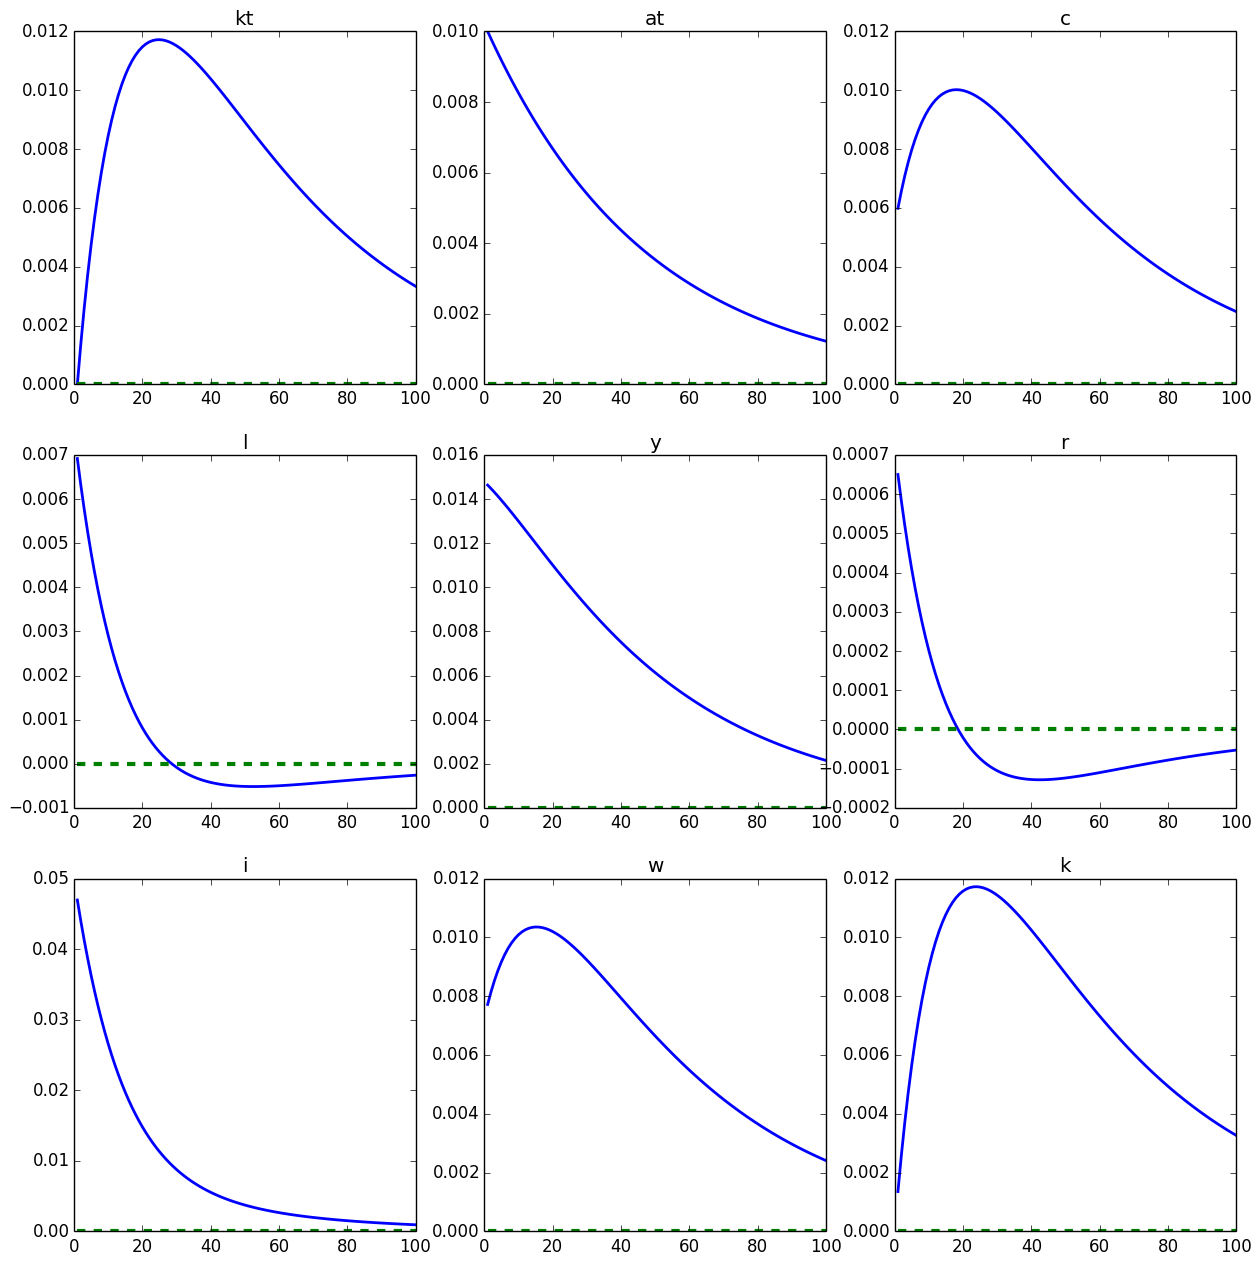

0.0048$ & $0.1383$\\
$\text{at}$ & $0.01$ & $0.9994$\\
$\text{c}$ & $0.0067$ & $0.9416$\\
$\text{l}$ & $0.0069$ & $0.9653$\\
$\text{y}$ & $0.0147$ & $1.0$\\
$\text{r}$ & $0.0007$ & $0.9476$\\
$\text{i}$ & $0.0468$ & $0.9835$\\
$\text{w}$ & $0.0082$ & $0.9753$\\
$\text{k}$ & $0.0048$ & $0.4123$
\end{tabular}


In [9]:
#######
# I.1 #
#######

################
# Define Model #
################

# Model Parameters
policies = ["c","l","y","r","i","w","k"];
states = ["kt","at"];
eqmConds = [EulerEquationLoss, InterestRateLoss, 
    LaborLeisureLoss, ProductionLoss, ResourceLoss,
    InvestmentLoss, WageLoss];

ss = buildParameters();

###############
# Solve Model #
###############

# Optimize
lambda = solveEqm(states, policies, eqmConds);

# Create Transition Matrix
T, P = getTransitionMatrix(lambda, ss, policies);

##############################
# Generate Impulse Responses #
##############################

s0 = [0.00 , 0.01];
pds = 100;
fig, impulseDf = generateImpulseResponsePlots(T, P, s0, pds, states, policies);

###############################
# Generate Simulation Moments #
###############################

CCpds = 1000;
momentDf = generateSimulationMoments(ss, T, P, CCpds, states, policies);

tabular(momentDf)
PyPlot.savefig("fig1.png");

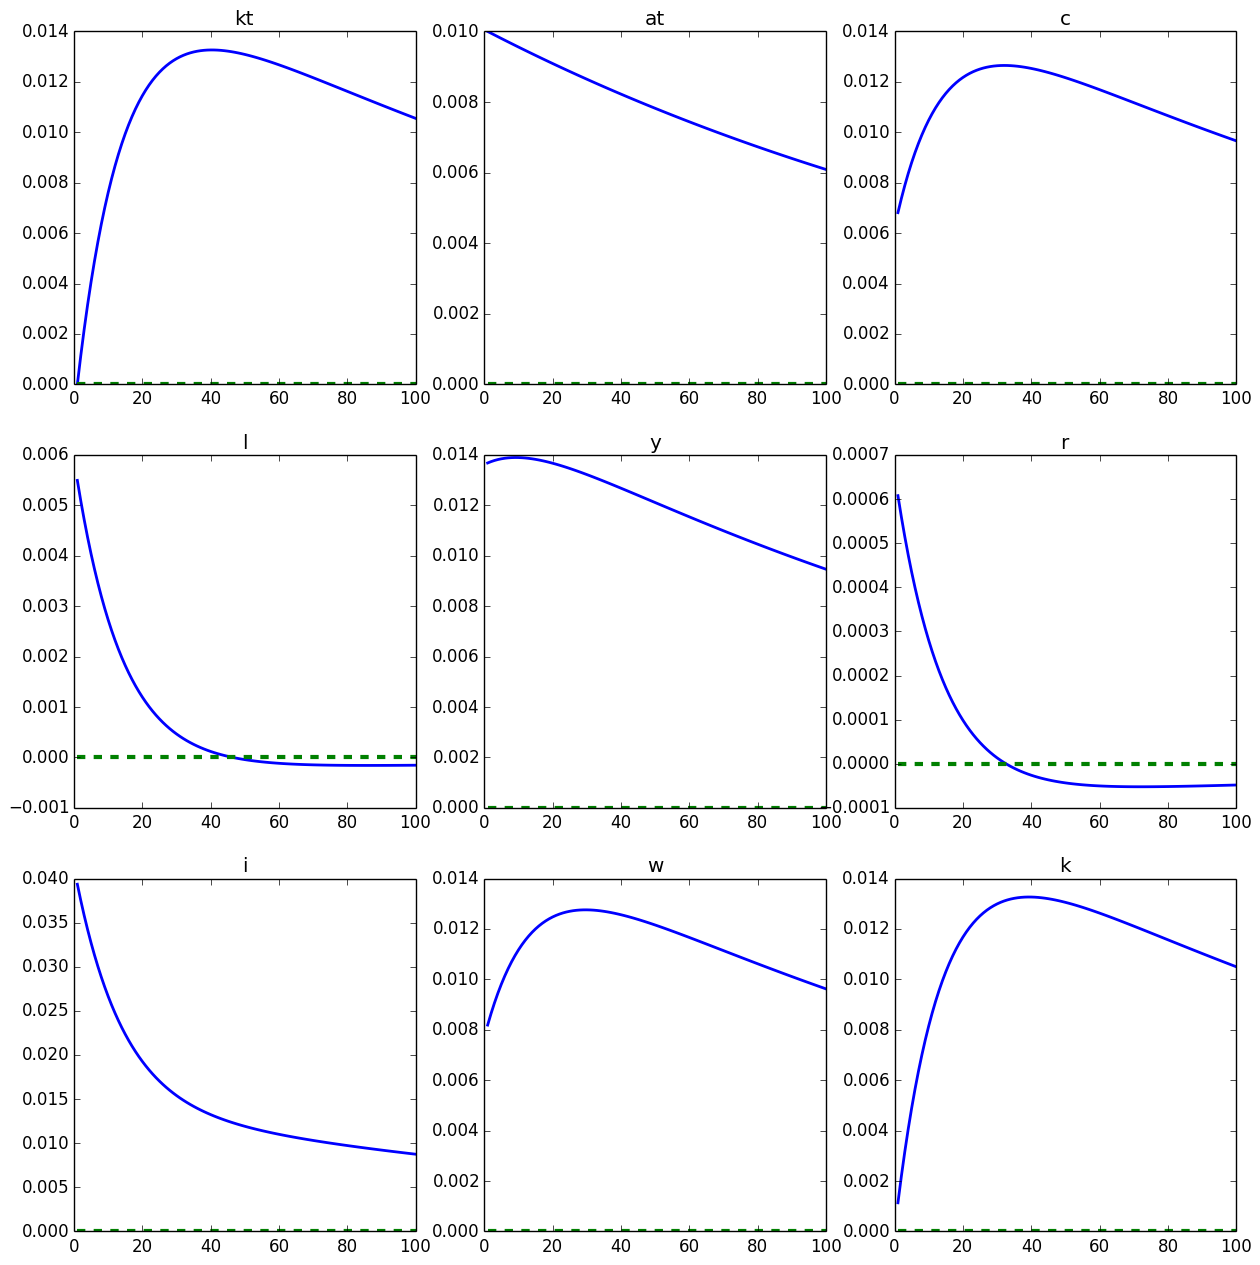

\begin{tabular}{ccc}
\hline
var & stddev & corrY\\
\hline
$\text{kt}$ & $0.0041$ & $0.1678$\\
$\text{at}$ & $0.0095$ & $0.9995$\\
$\text{c}$ & $0.0071$ & $0.9643$\\
$\text{l}$ & $0.0052$ & $0.9578$\\
$\text{y}$ & $0.0131$ & $1.0$\\
$\text{r}$ & $0.0006$ & $0.9517$\\
$\text{i}$ & $0.0372$ & $0.982$\\
$\text{w}$ & $0.0082$ & $0.9832$\\
$\text{k}$ & $0.0041$ & $0.4218$
\end{tabular}


In [10]:
#######
# I.2 #
#######

################
# Define Model #
################

# Model Parameters
policies = ["c","l","y","r","i","w","k"];
states = ["kt","at"];
eqmConds = [EulerEquationLoss, InterestRateLoss, 
    LaborLeisureLoss, ProductionLoss, ResourceLoss,
    InvestmentLoss, WageLoss];

ss = buildParameters();
ss["rhoA"] = 0.995;

###############
# Solve Model #
###############

# Optimize
lambda = solveEqm(states, policies, eqmConds);

# Create Transition Matrix
T, P = getTransitionMatrix(lambda, ss, policies);

##############################
# Generate Impulse Responses #
##############################

s0 = [0.00 , 0.01];
pds = 100;

fig, impulseDf = generateImpulseResponsePlots(T, P, s0, pds, states, policies);

###############################
# Generate Simulation Moments #
###############################

CCpds = 1000;
momentDf = generateSimulationMoments(ss, T, P, CCpds, states, policies);

tabular(momentDf)
PyPlot.savefig("fig2.png");

\begin{tabular}{ccc}
\hline
var & stddev & corrY\\
\hline
$\text{kt}$ & $0.005$ & $0.1435$\\
$\text{at}$ & $0.0097$ & $0.9999$\\
$\text{c}$ & $0.0069$ & $0.9369$\\
$\text{l}$ & $0.0085$ & $0.9659$\\
$\text{y}$ & $0.0155$ & $1.0$\\
$\text{r}$ & $0.0007$ & $0.948$\\
$\text{i}$ & $0.0499$ & $0.9836$\\
$\text{w}$ & $0.0076$ & $0.9575$\\
$\text{k}$ & $0.005$ & $0.4218$
\end{tabular}


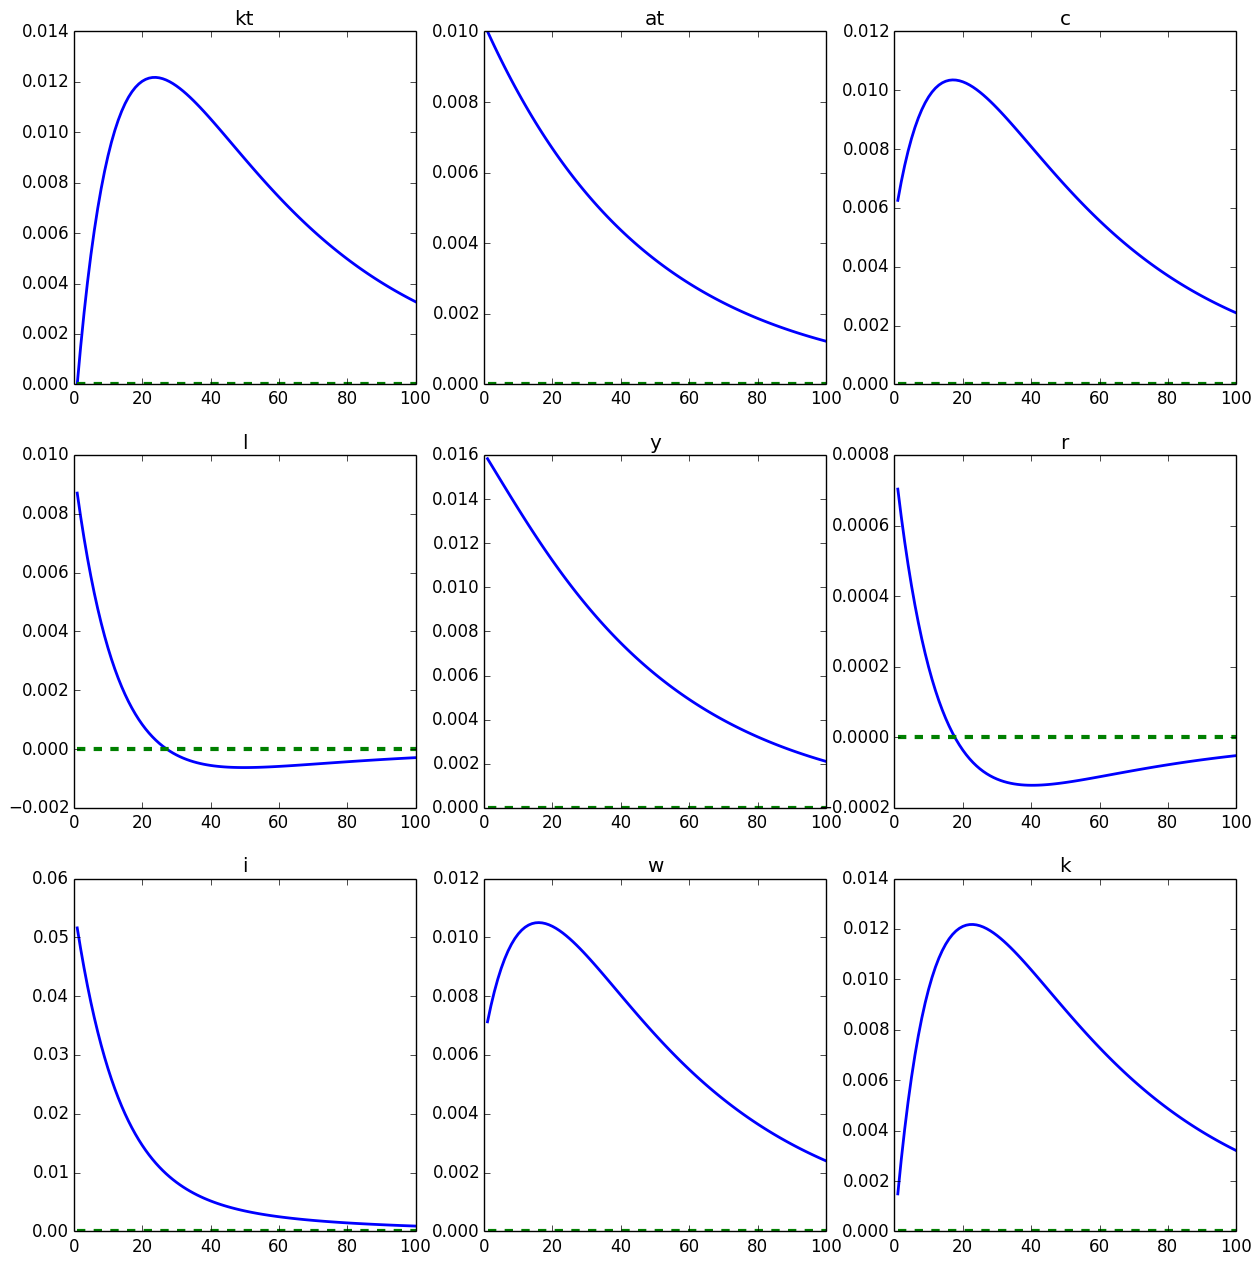

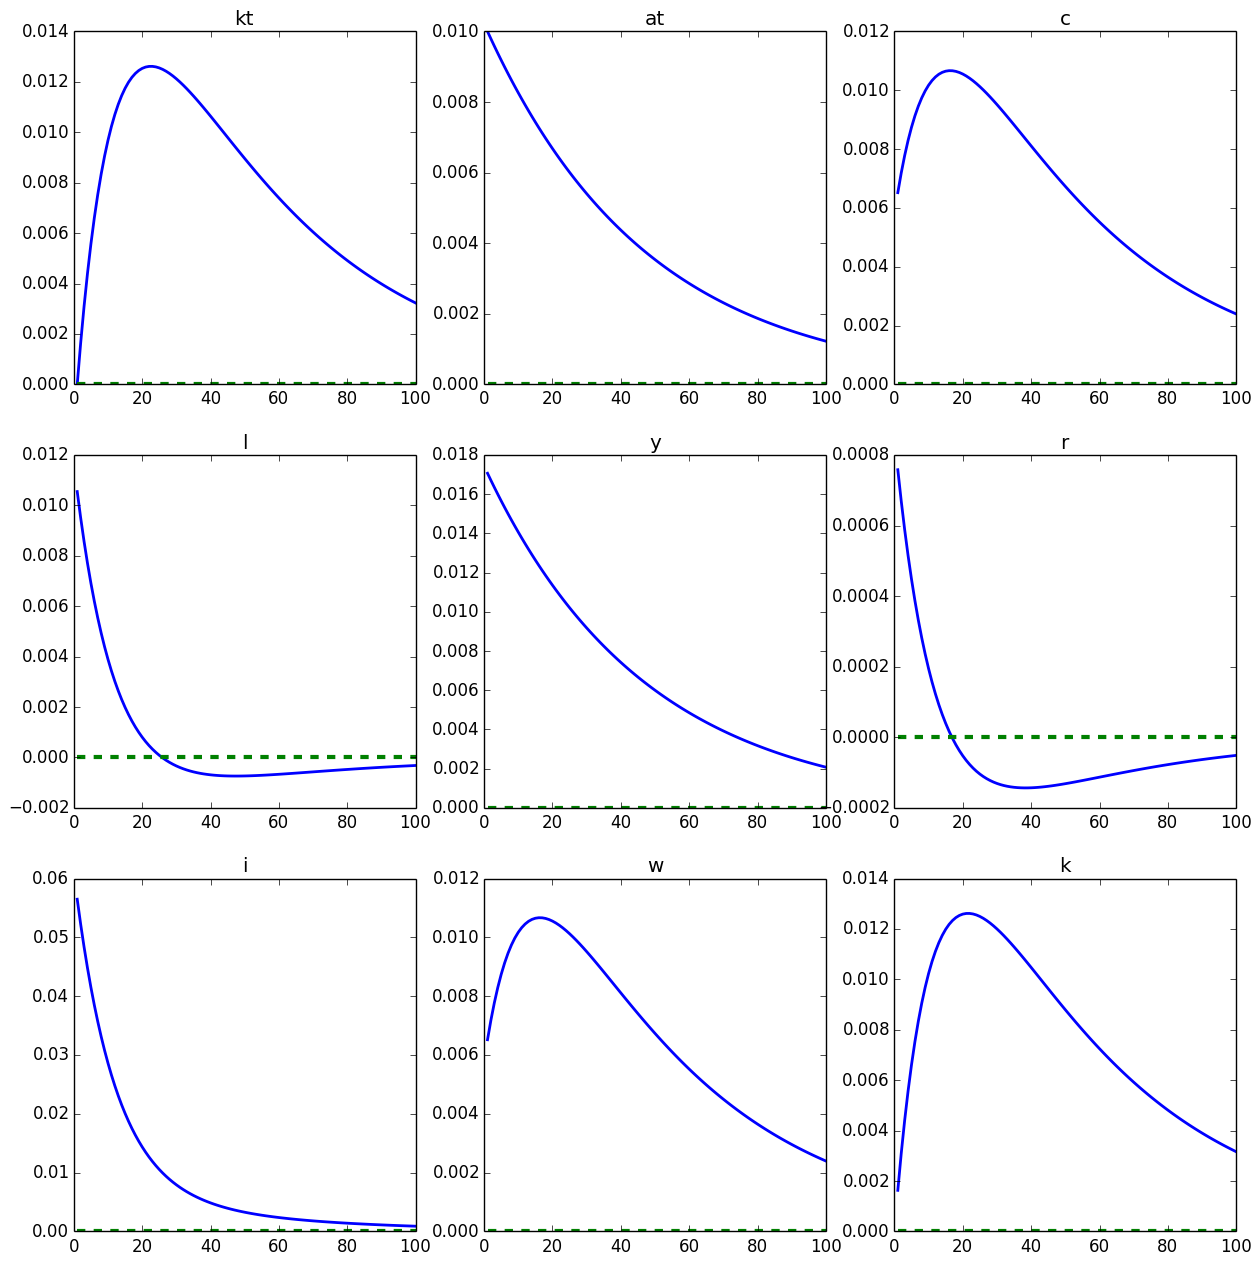

\begin{tabular}{ccc}
\hline
var & stddev & corrY\\
\hline
$\text{kt}$ & $0.0054$ & $0.1291$\\
$\text{at}$ & $0.0096$ & $1.0$\\
$\text{c}$ & $0.0071$ & $0.9278$\\
$\text{l}$ & $0.0102$ & $0.9651$\\
$\text{y}$ & $0.0164$ & $1.0$\\
$\text{r}$ & $0.0007$ & $0.9463$\\
$\text{i}$ & $0.054$ & $0.9829$\\
$\text{w}$ & $0.0071$ & $0.9278$\\
$\text{k}$ & $0.0054$ & $0.4094$
\end{tabular}


In [11]:
#########
# I.3.a #
#########

################
# Define Model #
################

s0 = [0.00 , 0.01];
pds = 100;
CCpds = 1000;

# Define new LL eqm condition
function ElasLaborLeisureLoss(lambda, stateVar)
    loss = (lambda["y$stateVar"] - lambda["c$stateVar"] 
    - (1.0 + ss["sigma"]) * lambda["l$stateVar"]);
    return loss
end

# Model Parameters
policies = ["c","l","y","r","i","w","k"];
states = ["kt","at"];
eqmConds = [EulerEquationLoss, InterestRateLoss, 
    ElasLaborLeisureLoss, ProductionLoss, ResourceLoss,
    InvestmentLoss, WageLoss];

ss = buildParameters();

#####################
# Larger Elasticity #
#####################

# Elast = 10
ss["sigma"] = 1.0 / 10.0; # Previous Spec was 1.0 / 4.0

lambda = solveEqm(states, policies, eqmConds);
T, P = getTransitionMatrix(lambda, ss, policies);
fig, impulseDf = generateImpulseResponsePlots(T, P, s0, pds, states, policies);
momentDf = generateSimulationMoments(ss, T, P, CCpds, states, policies);

tabular(momentDf)
PyPlot.savefig("fig3.png");

#######################
# Infinite Elasticity #
#######################

# Elast = infty
ss["sigma"] = 0.0; # Previous Spec was 1.0 / 4.0

lambda = solveEqm(states, policies, eqmConds);
T, P = getTransitionMatrix(lambda, ss, policies);
fig, impulseDf = generateImpulseResponsePlots(T, P, s0, pds, states, policies);
momentDf = generateSimulationMoments(ss, T, P, CCpds, states, policies);

tabular(momentDf)
PyPlot.savefig("fig4.png");

In [3]:
# Define Each Equilibrium Condition
# as a value to minimize

# value of Lambda for Euler Equation for stateVar
# e.g. \Lambda_{ee,k}

function EulerEquationLoss(lambda, stateVar)
    loss = (lambda["c$stateVar"]
    + lambda["rkt"] * lambda["k$stateVar"]
    + lambda["rat"] * ss["rhoA"] * Float64(stateVar == "at")
    - lambda["ckt"] * lambda["k$stateVar"]
    - lambda["cat"] * ss["rhoA"] * Float64(stateVar == "at"));
    return loss
end

function InterestRateLoss(lambda, stateVar)
    loss = (ss["alpha"] * (ss["ky_star"])^-1.0 * (lambda["y$stateVar"]) 
    - ss["alpha"] * (ss["ky_star"])^-1.0 * Float64(stateVar == "kt")
    - (1.0 + ss["rstar"]) * lambda["r$stateVar"]);
    return loss
end

function LaborLeisureLoss(lambda, stateVar)
    loss = (lambda["y$stateVar"] - lambda["c$stateVar"] 
    - (1.0 - ss["lstar"])^-1.0 * lambda["l$stateVar"]);
    return loss
end

function ProductionLoss(lambda, stateVar)
    loss = (lambda["y$stateVar"]
    - Float64(stateVar == "at")
    - ss["alpha"] * Float64(stateVar == "kt")
    - (1.0-ss["alpha"]) * lambda["l$stateVar"]);
    return loss
end

function ResourceLoss(lambda, stateVar)
    loss = (lambda["y$stateVar"] 
    - ss["cy_star"] * lambda["c$stateVar"]
    - ss["ky_star"] * (1.0 + ss["gamma"]) * lambda["k$stateVar"]
    + ss["ky_star"] * (1.0 - ss["delta"]) * Float64(stateVar == "kt"));
    return loss
end

function InvestmentLoss(lambda, stateVar)
    loss = ((1 - ss["cy_star"]) * lambda["i$stateVar"]
    + ss["cy_star"] * lambda["c$stateVar"]
    - lambda["y$stateVar"]);
    return loss
end

function WageLoss(lambda, stateVar)
    loss = (lambda["w$stateVar"] 
    - lambda["y$stateVar"]
    + lambda["l$stateVar"]);
    return loss
end

WageLoss (generic function with 1 method)

In [ ]:
function solveEqm(states, policies, eqmConds)
    
    # Convert Array to Named Dictionary of Lambda vars
    function toLambda(x)
        lambda = Dict{AbstractString, Float64}();    
        for (i, state) in enumerate(states)
            for (j, policy) in enumerate(policies)
                lambda["$policy$state"] = x[size(policies, 1) * (i-1) + j];
            end
        end
        return lambda
    end
    
    # Sum of squared differences of each
    # eqm condition's violation
    function objLambda(lambda)

        value = sum([eqmCond(lambda, stateVar)
            for stateVar in states,
            eqmCond in eqmConds] .^ 2);

        # Add a penalty to keep kk < 1
        value += 100 * (lambda["kkt"] > 1);
        return value
    end    
    
    objFn = x -> objLambda(toLambda(x));
    x0 = zeros(2*(size(states,1) + size(policies,1)));
    res = optimize(objFn, x0, LBFGS())
    return toLambda(res.minimizer)
end

In [5]:
function getTransitionMatrix(lambda, ss, policies)
    # Transition Matrix
    T = [[lambda["kkt"] lambda["kat"]]; 
        [0 ss["rhoA"]]];
    # Policy Matrix
    P = Array{Float64}(size(policies, 1), 2);

    for (i,policy) in enumerate(policies)
        P[i, 1] = lambda["$(policy)kt"]
        P[i, 2] = lambda["$(policy)at"]
    end
        
    return T, P
end

getTransitionMatrix (generic function with 1 method)

In [6]:
# Generate Impulse Responses

function getImpulseData(T, P, s0, pds)
    # Define States by Applying Transition Matrix
    s = Array{Float64}(2,pds);

    # Define Policy Variables
    policy = Array{Float64}(size(P, 1), pds);

    s[:,1] = s0;
    policy[:,1] = P * s0;
    for p in 2:pds
        s[:,p] = T * s[:,p-1];
        policy[:,p] = P * s[:,p];
    end

    return (s, policy)
end

function makeImpulseDf(s, policy, columnNames)
    
    impulseData = DataFrame([s' policy']);

    for i in 1:size(vcat(states,policies), 1)
        rename!(impulseData, symbol("x$i"), symbol(columnNames[i]));
    end
    return impulseData
end

function generateImpulseResponsePlots(T, P, s0, pds, states, policies)
    s, policy = getImpulseData(T, P, s0, pds);
    
    columnNames = vcat(states,policies);
    impulseData = makeImpulseDf(s, policy, columnNames);
    
    fig = plotImpulseResponses(impulseData)
    
    return fig, impulseData
end

# Plot Panel of Impulse Responses
function plotImpulseResponses(impulseData)
    
    columnNames = map(string, names(impulseData));
    
    # Number of Periods
    pds = size(impulseData, 1);
    
    # Plot Single Impulse response function
    function plotImpulse(plt, impulseData, series)
        plt.plot(1:pds, impulseData[symbol(series)], 
        label=series, linewidth=2);
    end
    
    # Get dimensions
    dim = ceil(sqrt(size(columnNames, 1)));
    
    # Plot Each Series
    fig = plt.figure(figsize=(dim*5,dim*5))
    for (i, label) in enumerate(columnNames)
        plt.subplot(dim,dim,i);
        plotImpulse(plt, impulseData, label)
        plt.plot(1:pds, zeros(pds), linewidth=3, linestyle="dashed")
        plt.title(label)
    end
    plt.show()
    
    return fig
end

plotImpulseResponses (generic function with 1 method)

In [ ]:
# Moment Simulation Code

function getSimulatedSSData(T, P, s0, pds, shockDistribution)

    # Define States by Applying Transition Matrix
    s = Array{Float64}(2,pds);

    # Define Policy Variables
    policy = Array{Float64}(size(P, 1),pds);

    s[:,1] = s0;
    policy[:,1] = P * s0;
    for p in 2:pds
        # Apply Transition Matrix
        s[:,p] = T * s[:,p-1];
        
        # Add Random Shock to Productivity
        s[2,p] += rand(shockDistribution);
        
        # Compute Updated Policies
        policy[:,p] = P * s[:,p];
    end

    return (s, policy)
end

function generateSimulationMoments(ss, T, P, CCpds, states, policies)

    # Normal Shocks
    meanA = 0;
    stdA = ss["sigmaA"];
    shockDistribution = Normal(meanA, stdA);

    # Initialize at SS
    s0 = [0.0, 0.0];

    # Construct Simulated Data
    s, policy = getSimulatedSSData(T, P, s0, CCpds, shockDistribution)

    # Construct DataFrame
    columnNames = vcat(states,policies);
    simulatedData = DataFrame([s' policy']);
    for i in 1:size(vcat(states,policies), 1)
        rename!(simulatedData, symbol("x$i"), symbol(columnNames[i]));
    end

    # Generate Growth Path
    trend = exp(ss["gamma"] * (1:CCpds));

    # Apply steady state and take logs
    # Capital, Productivity, Consumption, Investment scale with growth
    for s in ["k","y","c","i","kt","at"]
        simulatedData[symbol("$s")] = log(exp(simulatedData[symbol("$s")]) 
            .* trend * ss[s]);
    end

    for s in ["r","w","l"]
        simulatedData[symbol("$s")] = log(exp(simulatedData[symbol("$s")]) 
            * ss[s]);
    end

    # Apply HP Filter to *each* variable
    filteredData = deepcopy(simulatedData);
    filter1600 = s -> Vector(s) - hp_filter(Vector(s), 1600.0);
    map(s -> filteredData[symbol("$s")] = 
        filter1600(filteredData[symbol("$s")]), columnNames);

    ###################
    # Compute Moments #
    ###################

    # Clean, Round
    clean = y -> round(map(x -> x[1], y), 4) ;
    corrY = s -> cor(s, filteredData[:y]);

    momentData = DataFrame();
    momentData[:var] = columnNames;
    momentData[:stddev] = clean(colwise(std, filteredData));
    momentData[:corrY] = clean(colwise(corrY, filteredData));
    
    return momentData
end

In [8]:
# HP Filter Code from
# http://www.econforge.org/posts/2014/juil./28/cef2014-julia/

function hp_filter(y::Vector{Float64}, lambda::Float64)
    n = length(y)
    @assert n >= 4

    diag2 = lambda*ones(n-2)
    diag1 = [ -2lambda; -4lambda*ones(n-3); -2lambda ]
    diag0 = [ 1+lambda; 1+5lambda; (1+6lambda)*ones(n-4); 1+5lambda; 1+lambda ]

    D = spdiagm((diag2, diag1, diag0, diag1, diag2), (-2,-1,0,1,2))

    D\y
end

hp_filter (generic function with 1 method)